# Part A: Data Cleaning and Preprocessing

## 1. Loading the Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import re
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer

In [2]:
from datasets import load_dataset

dataset_id = "facehuggerapoorv/resume-jd-match"
raw_datasets = load_dataset(dataset_id)

# raw_datasets will contain 'train' and 'test' splits
print(raw_datasets)

README.md:   0%|          | 0.00/411 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/8.07M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1759 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6241
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1759
    })
})


In [3]:
# Inspection
train_df = raw_datasets['train'].to_pandas()
print(train_df['label'].value_counts())

label
No Fit           3143
Potential Fit    1556
Good Fit         1542
Name: count, dtype: int64


In [4]:
test_df = raw_datasets['test'].to_pandas()
print(test_df['label'].value_counts())

label
No Fit           857
Good Fit         458
Potential Fit    444
Name: count, dtype: int64


In [5]:
# Identify unique labels
label_list = train_df['label'].unique().tolist()
num_labels = len(label_list)
print(f"Number of classes: {num_labels}")

Number of classes: 3


In [6]:
print(f"Dataset shape: {train_df.shape}")
print(f"Columns: {train_df.columns}")
print(f"Test Dataset shape: {test_df.shape}")
print(train_df.head())

Dataset shape: (6241, 2)
Columns: Index(['text', 'label'], dtype='object')
Test Dataset shape: (1759, 2)
                                                text   label
0  For the given job description <<Net2Source Inc...  No Fit
1  For the given job description <<At Salas OBrie...  No Fit
2  For the given job description <<Schweitzer Eng...  No Fit
3  For the given job description <<Mizick Miller ...  No Fit
4  For the given job description <<Life at Capgem...  No Fit


## Cleaning the data

The text format (For the given job description <<...) indicates this dataset was likely originally formatted for Instruction Tuning (using LLMs).

For a Classification Project like ours, that specific prefix ("For the given job description...") is "noise" as it appears in every single row and takes up valuable token/embedding space without adding unique information. We should clean that out.

We need to remove the static prompt text to ensure the model focuses on the actual Job Description (JD) and Resume content.

In [7]:
def clean_prompt_format(text):
    if not isinstance(text, str):
        return ""

    # Removing static instruction prefix
    text = re.sub(r'For the given job description\s*<<', '', text)

    # Removing closing brackets
    text = text.replace('>>', '')

    # Standard cleaning (whitespace, etc.)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Applying to both Train and Test dataframes
train_df['cleaned_text'] = train_df['text'].apply(clean_prompt_format)
test_df['cleaned_text'] = test_df['text'].apply(clean_prompt_format)

print("Original start:", train_df['text'].iloc[0][:50])
print("Cleaned start:", train_df['cleaned_text'].iloc[0][:50])

Original start: For the given job description <<Net2Source Inc. is
Cleaned start: Net2Source Inc. is an award-winning total workforc


## Pre-processing the data

### Label Encoding & Analysis

Our labels are strings ("No Fit"). ML Models are best when working with numbers (0, 1, etc.). We need to map them and ensure the mapping is consistent across Train and Test sets.

In [8]:
le = LabelEncoder()

# Transforming both datasets with same encoder
train_df['label_id'] = le.fit_transform(train_df['label'])
test_df['label_id'] = le.transform(test_df['label'])

# Printing the mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Good Fit': np.int64(0), 'No Fit': np.int64(1), 'Potential Fit': np.int64(2)}


In [9]:
# Checking for class balance
print("Train Class Distribution:\n", train_df['label'].value_counts())

Train Class Distribution:
 label
No Fit           3143
Potential Fit    1556
Good Fit         1542
Name: count, dtype: int64


In [10]:
print("Test Class Distribution:\n", test_df['label'].value_counts())

Test Class Distribution:
 label
No Fit           857
Good Fit         458
Potential Fit    444
Name: count, dtype: int64


## Visualizations

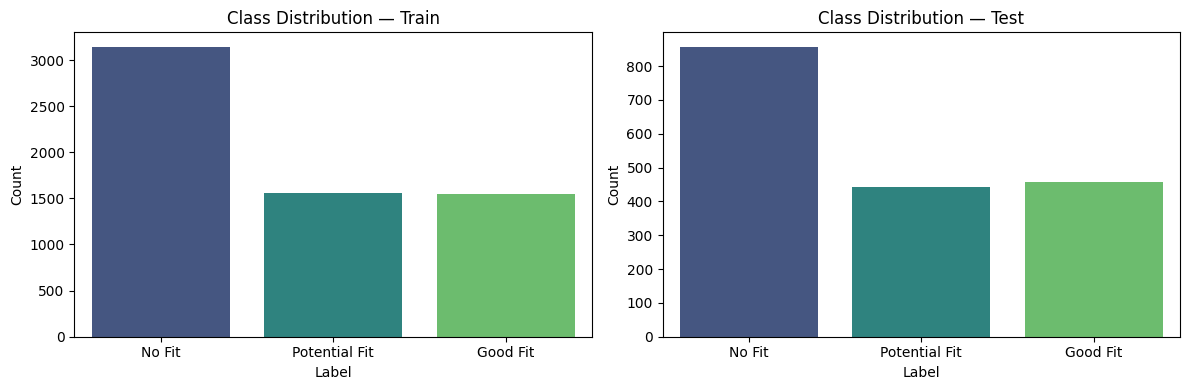

In [11]:
# Class Disribution
ig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(data=train_df, x='label', palette='viridis', ax=axes[0], hue= 'label', legend= None)
axes[0].set_title("Class Distribution — Train")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Count")

sns.countplot(data=test_df, x='label', palette='viridis', ax=axes[1], hue= 'label', legend= None)
axes[1].set_title("Class Distribution — Test")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show();

Bias Risk: We can clearly see the imbalance in the data. The classifier is to be trained on two times more "No Fit" examples than "Potential Fit" or "Good Fit" examples.

A model trained on this data will be naturally biased towards predicting "No Fit." It has far more examples of what a "No Fit" looks like, making it easier to be highly accurate on that class, potentially at the expense of accuracy on the "Potential Fit" and "Good Fit" classes.

Given the imbalance, using simple `Accuracy` as the primary evaluation metric would be misleading. A model could achieve high accuracy (around 60-70%) simply by guessing **No Fit** frequently.

Therefore, any model's performance must be evaluated using metrics like `F1-Score`, `Precision`, `Recall`, and the Confusion Matrix, which reveal performance for each individual class, especially the minority classes.

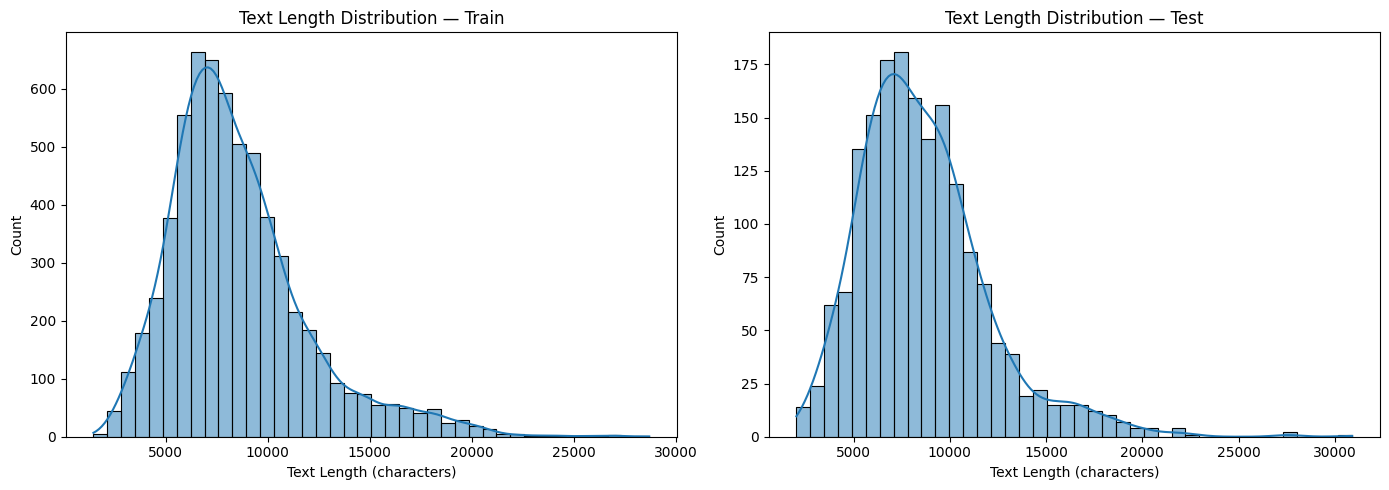

In [12]:
# Text-Length Distribution

train_df['text_length'] = train_df['cleaned_text'].str.len()
test_df['text_length']  = test_df['cleaned_text'].str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(train_df['text_length'], bins=40, kde=True, ax=axes[0])
axes[0].set_title("Text Length Distribution — Train")
axes[0].set_xlabel("Text Length (characters)")

sns.histplot(test_df['text_length'], bins=40, kde=True, ax=axes[1])
axes[1].set_title("Text Length Distribution — Test")
axes[1].set_xlabel("Text Length (characters)")

plt.tight_layout()
plt.show();

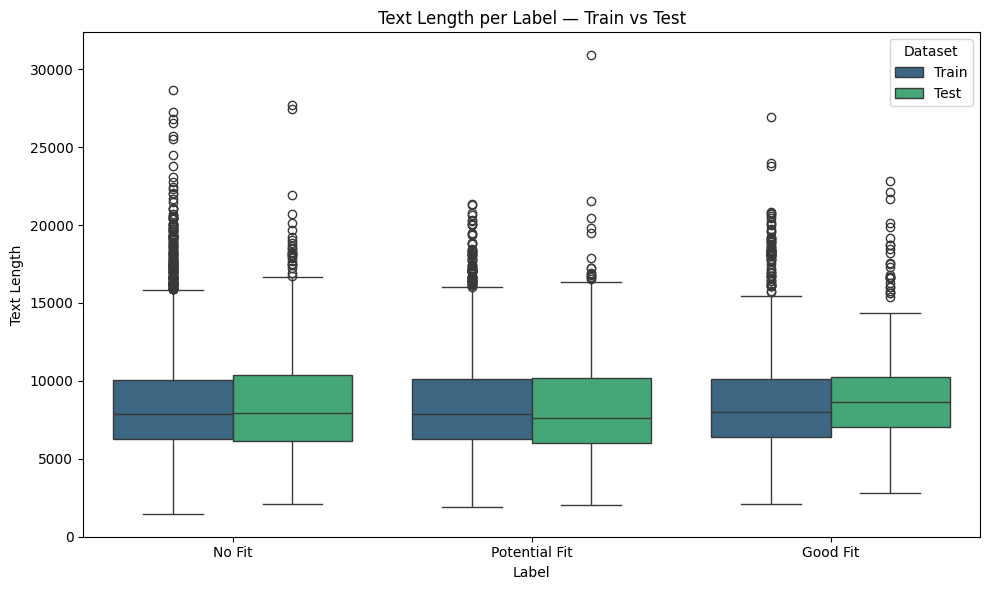

In [13]:
# Text Length by Label

train_tmp = train_df.copy()
train_tmp["dataset"] = "Train"

test_tmp = test_df.copy()
test_tmp["dataset"] = "Test"

combined = pd.concat([train_tmp, test_tmp], axis=0)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=combined,
    x="label",
    y="text_length",
    hue="dataset",
    palette="viridis"
)

plt.title("Text Length per Label — Train vs Test")
plt.xlabel("Label")
plt.ylabel("Text Length")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

We can see that the dataset has **consistent distribution**: The overall shape, location, and spread of the boxes and whiskers are very similar across all six distributions.

This is a strong indicator of high data quality.

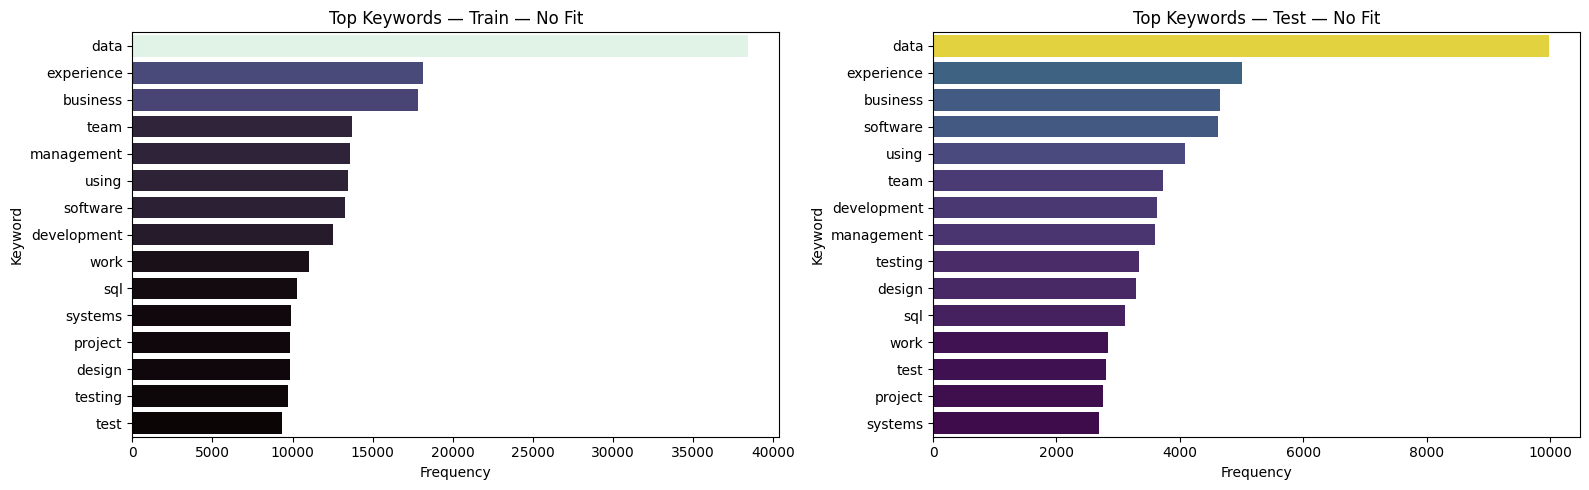

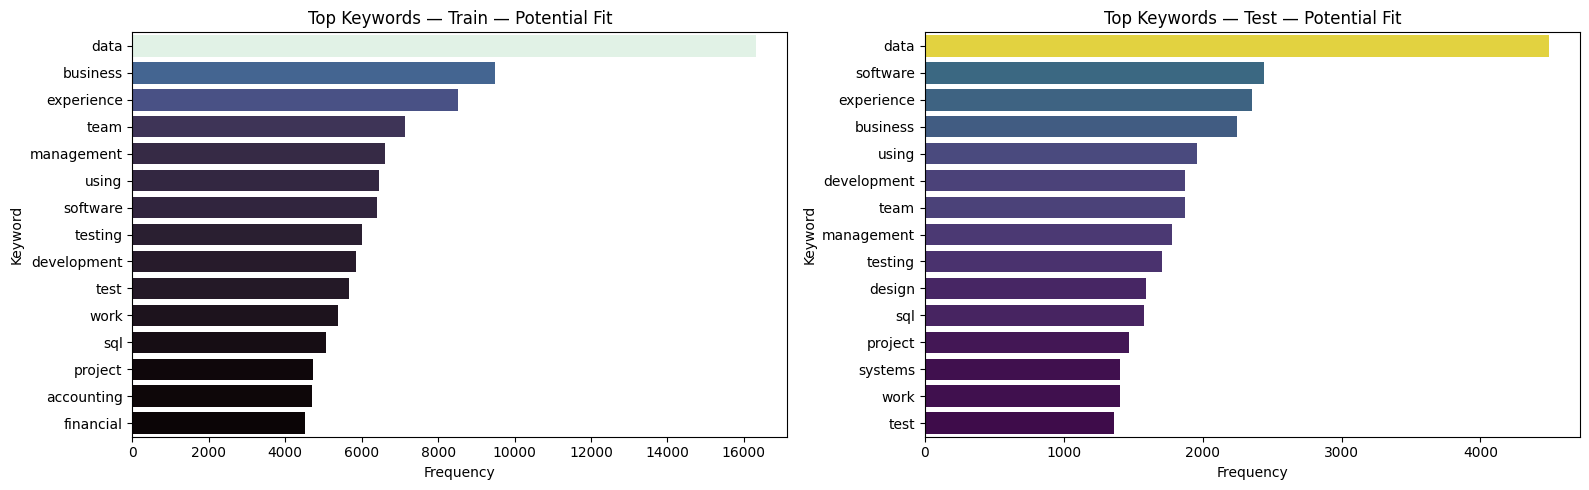

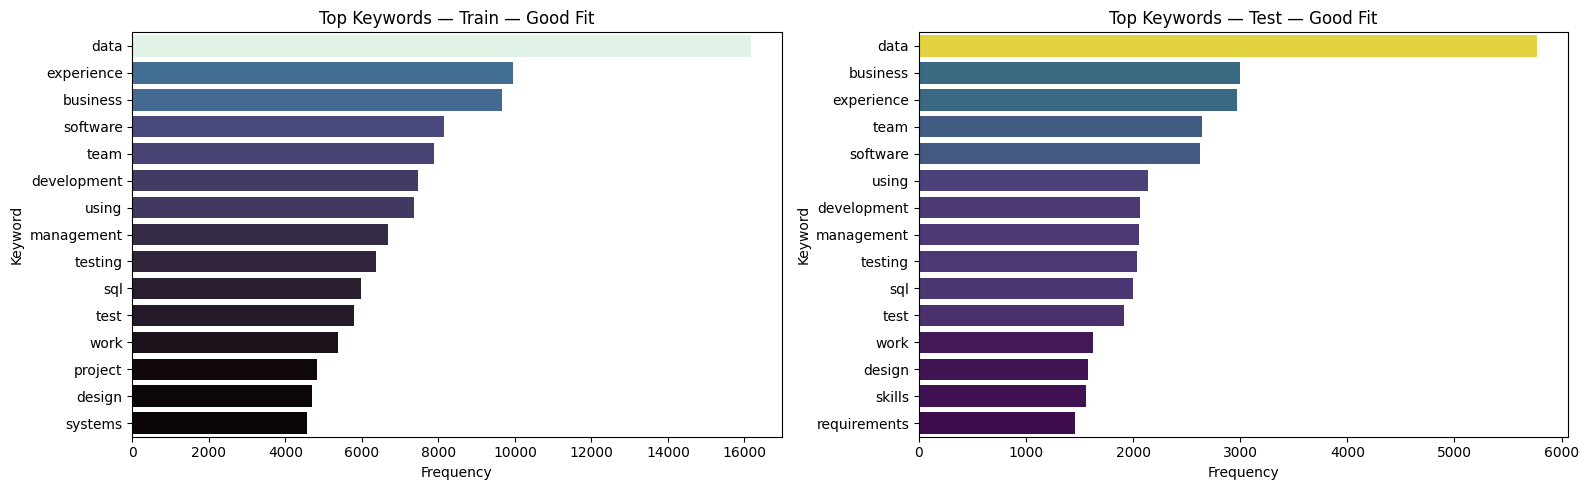

In [14]:
cv = CountVectorizer(stop_words='english', max_features=20)

for cls in train_df['label'].unique():

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Train dataset
    text_train = train_df[train_df['label']==cls]['cleaned_text']
    X_train = cv.fit_transform(text_train)
    freqs_train = np.array(X_train.sum(axis=0)).flatten()
    vocab_train = np.array(cv.get_feature_names_out())
    order = np.argsort(freqs_train)[::-1]

    sns.barplot(
        x=freqs_train[order][:15],
        y=vocab_train[order][:15],
        palette='mako',
        ax=axes[0],
        hue= freqs_train[order][:15],
        legend= None
    )
    axes[0].set_title(f"Top Keywords — Train — {cls}")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Keyword")

    # Test dataset
    text_test = test_df[test_df['label']==cls]['cleaned_text']
    X_test = cv.fit_transform(text_test)
    freqs_test = np.array(X_test.sum(axis=0)).flatten()
    vocab_test = np.array(cv.get_feature_names_out())
    order_test = np.argsort(freqs_test)[::-1]

    sns.barplot(
        x=freqs_test[order_test][:15],
        y=vocab_test[order_test][:15],
        palette='viridis',
        ax=axes[1],
        hue= freqs_test[order_test][:15],
        legend= None
    )
    axes[1].set_title(f"Top Keywords — Test — {cls}")
    axes[1].set_xlabel("Frequency")
    axes[1].set_ylabel("Keyword")

    plt.tight_layout()
    plt.show()

We can visually note some differences between the words that are most commonly visible in each category: `Good Fit`, `Potential Fit` and `No Fit` like `data`, `experience`, `team` and more. However, we can dive deeper with the following **WordCloud visualization** too:


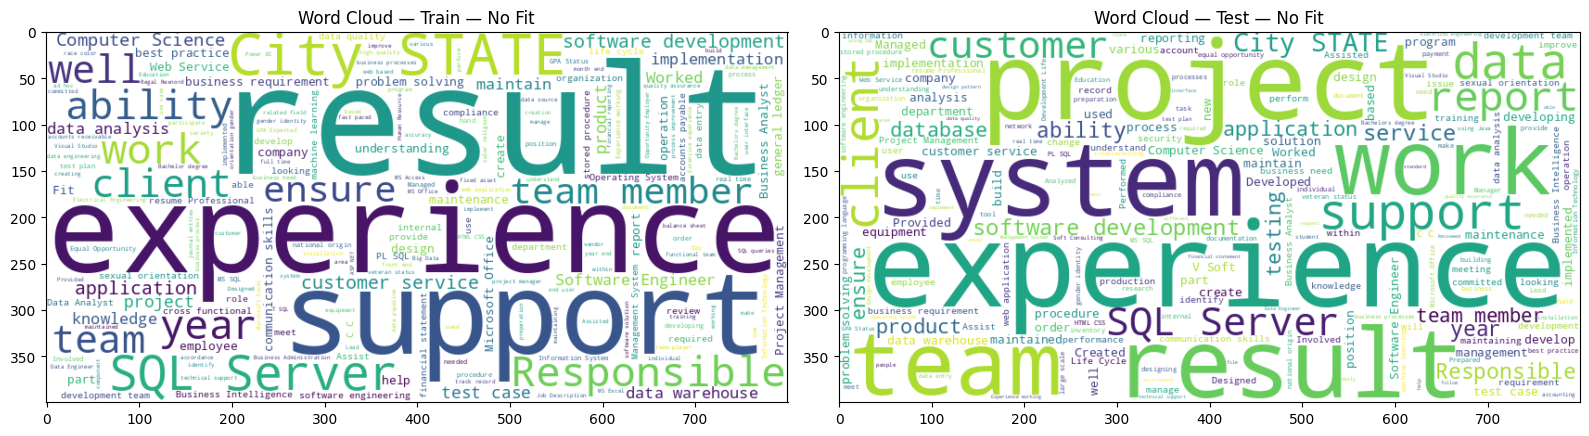

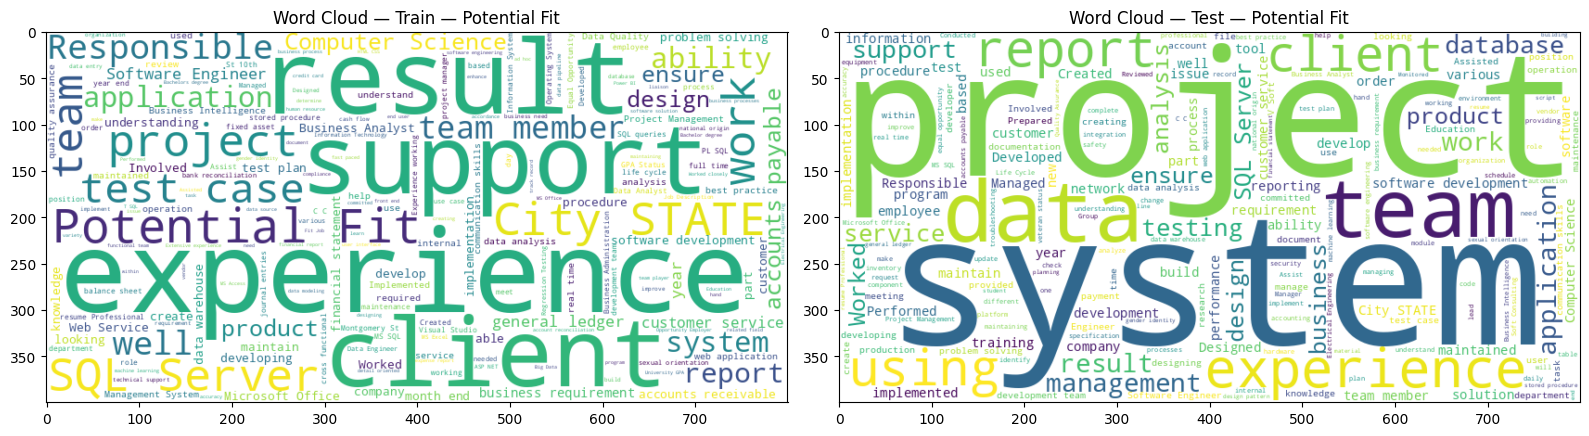

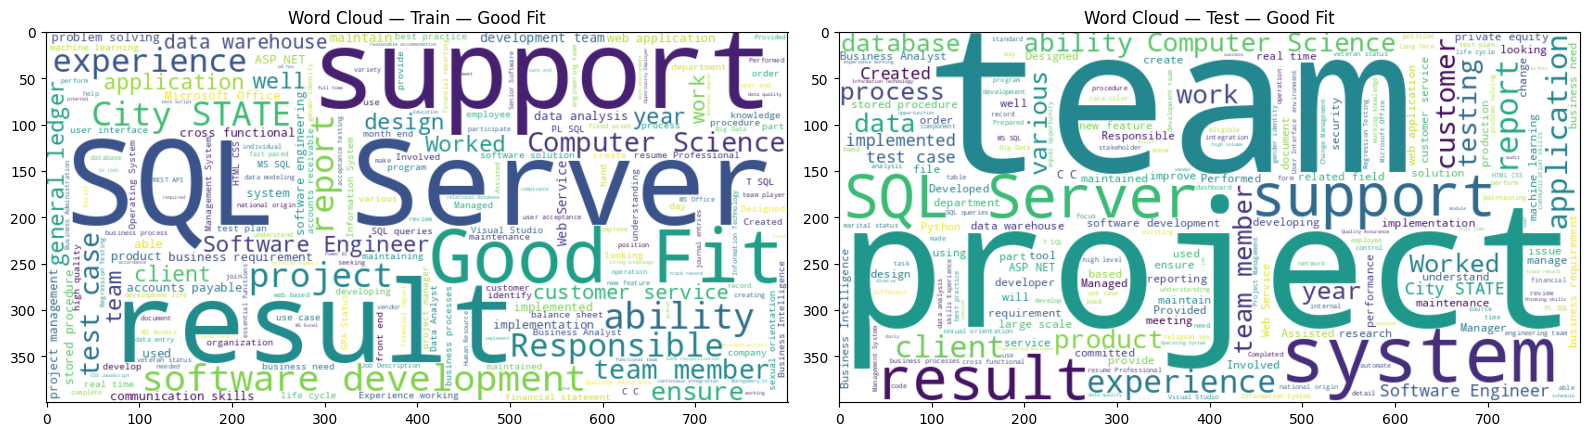

In [15]:
# Word CLouds

for cls in train_df['label'].unique():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Train
    text_train = " ".join(train_df[train_df['label']==cls]['cleaned_text'].astype(str).tolist())
    wc_train = WordCloud(width=800, height=400, background_color='white').generate(text_train)
    axes[0].imshow(wc_train, interpolation='bilinear')
    axes[0].set_title(f"Word Cloud — Train — {cls}")
    axes[0].axis("on")

    # Test
    text_test = " ".join(test_df[test_df['label']==cls]['cleaned_text'].astype(str).tolist())
    wc_test = WordCloud(width=800, height=400, background_color='white').generate(text_test)
    axes[1].imshow(wc_test, interpolation='bilinear')
    axes[1].set_title(f"Word Cloud — Test — {cls}")
    axes[1].axis("on")

    plt.tight_layout()
    plt.show();

**Insights: The Value of Keywords and Being Specific**

* `Computer Science` is notably large in the **Good Fit** word clouds. This suggests a formal educational background or direct tie to the field is a stronger indicator of a Good Fit than a Potential Fit or No Fit.

* The terms `application`, `project`, and `test case` are highly visible in the **Potential** and **Good Fit** clouds, implying that a focus on deliverables (projects/applications) and quality assurance (test cases) is crucial for a positive outcome.

* Both of these suggest that there is a strong correlation with foundational knowledge, customer/stakeholder interaction, and tangible outcomes.

* The **No Fit** cloud contains very generic, business/workplace terms like `support`, `experience`, `team`, and more. While these are necessary, they are not differentiating factors. Their large size suggests that these are the minimum common denominator words, and their over representation without other key technical terms leads to a "No Fit" classification.

## Feature Engineering

**Creating a Validation Split**:
This allows us to tune the model without touching the final Test set

In [16]:
train_sub, val_sub = train_test_split(
    train_df,
    test_size=0.1,
    random_state=15,
    stratify=train_df['label_id'] # Keeping class ratios same
)

# Convert all three to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_sub)
val_dataset = Dataset.from_pandas(val_sub)
test_dataset = Dataset.from_pandas(test_df)

# Combine into a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'cleaned_text', 'label_id', 'text_length', '__index_level_0__'],
        num_rows: 5616
    })
    validation: Dataset({
        features: ['text', 'label', 'cleaned_text', 'label_id', 'text_length', '__index_level_0__'],
        num_rows: 625
    })
    test: Dataset({
        features: ['text', 'label', 'cleaned_text', 'label_id', 'text_length'],
        num_rows: 1759
    })
})


**Tokenization**:

Now we convert the cleaned text into numbers. Since resumes and JDs are long, we will use truncation=True to cut them off at 512 tokens.

We use 512 tokens because it is the maximum sequence length models like BERT, RoBERTa, DistilBERT, etc. were pretrained on, giving the best balance between information retention and performance.

In [17]:
# Loading DistilBERT tokenizer (fast and efficient)
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["cleaned_text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

# Applying it to all splits (train, validation, test)
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5616 [00:00<?, ? examples/s]

Map:   0%|          | 0/625 [00:00<?, ? examples/s]

Map:   0%|          | 0/1759 [00:00<?, ? examples/s]

Formatting for PyTorch:

In [18]:
# Remove columns we don't need anymore to save memory
cols_to_remove = ['text', 'cleaned_text', 'label']

tokenized_datasets = tokenized_datasets.remove_columns(cols_to_remove)
tokenized_datasets = tokenized_datasets.rename_column("label_id", "labels")

columns_to_remove = ['__index_level_0__']
# Separate removal as this column is not present in test dataset
for split in tokenized_datasets.keys():
    # Check if the column exists
    if '__index_level_0__' in tokenized_datasets[split].column_names:
        tokenized_datasets[split] = tokenized_datasets[split].remove_columns(columns_to_remove)

In [19]:
# Set format
tokenized_datasets.set_format("torch")

In [20]:
# Final Check
print("Shape of input_ids:", tokenized_datasets['train'][0]['input_ids'].shape)
print("Label example:", tokenized_datasets['train'][0]['labels'])

Shape of input_ids: torch.Size([512])
Label example: tensor(1)


## Pushing it to HuggingFace for my teammates to use

As we are collaborating on different devices, and as we are already using HuggingFace for loading the data, I am using the same to save the clean and embedded data below:

In [21]:
tokenized_datasets.push_to_hub("sibi-seeni/tokenized-resume-data")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :  11%|#1        |  586kB / 5.23MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########|  557kB /  557kB            

                              : 100%|##########|  557kB /  557kB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :  99%|#########9| 1.43MB / 1.44MB            

CommitInfo(commit_url='https://huggingface.co/datasets/sibi-seeni/tokenized-resume-data/commit/c30d73389ec8a4bf987e34949ef9871e07f7af2e', commit_message='Upload dataset', commit_description='', oid='c30d73389ec8a4bf987e34949ef9871e07f7af2e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/sibi-seeni/tokenized-resume-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='sibi-seeni/tokenized-resume-data'), pr_revision=None, pr_num=None)